# Background

I wrote this to talk to my kids about the COVID-19 epidemic, why the schools were closed, and why we are limiting drastically our social interaction. This is a jupyter notebook so there is code, and, well, this grew quite a bit beyond what kids will have the patience for, but the code can hopefull be skipped and the text and graphics are enough and interesting on their own.

I believe that "back-of-enveloppe" simulations and visualizations such as this one can help build an intuition and understanding about what is happening, why this is the right and rational thing to do. Also since this is expressed as relatively simple code (and the kids have interest in this), I believe that it brings some sense of control as one can explore "what if" scenarios by modifying variables or functions (this is written with this in mind - if you can code, you can explore the effect of various kind of measures to control the epidemic). Unlike SEIR models using differential equations, this is a stochastic simulation that can be easier to interact with, requiring knowing only a bit of Python.

**To be clear, this is not yet an another data scientist playing the expert and making predictions. While the parameters are chosen to match empirical observations, and the simulation appear to give results aligned with experts, this is meant to have non-subject matter experts build a hands-on understanding, may be play the armchair specialists, and possibly experiment with "what-if" scenarios.**

# Setting up the environment

We need the following packages for everything to work.

**Note: if using Google Colab, creating a cell with the
following should be enough have the "import" section below
working.**
```
%%sh
apt-get install libgraphviz-dev
pip install pygraphviz
```

In [34]:
from dataclasses import dataclass, field
from IPython.core.display import display
import pygraphviz as gv
from rpy2.ipython.ggplot import image_png
import rpy2.ipython.html
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects.lib import dplyr
import rpy2.robjects as ro
import networkx as nx
import random
from typing import List

rpy2.ipython.html.init_printing()

We also need to ensure that the we have the companion code for this notebook (boilerplate code is in a module to avoid clutter in the notebook). The following cell should work automatically, but it is does not just download the file manually from https://github.com/lgautier/rhinoceros/blob/master/rhinoceros.py.

In [2]:
%%sh

if [ ! -f rhinoceros.py ]
then
  wget https://raw.githubusercontent.com/lgautier/rhinoceros/master/rhinoceros.py
fi

Now import the module and we are almost ready to go.

In [3]:
import rhinoceros as rh
from rhinoceros import Population
from rhinoceros import Disease
from rhinoceros import Monitor

The very last setup step is to ensure that while this simulation is stochastic (has random components) it will looks the same everywhere by default.

In [4]:
random.seed = 123

## Data structures

A population (class `Population`) is represented by:
- a network (graph) to represent the connections between members of that population. Connections here do not mean family connection, or friendships, but more the contact 2 individuals might have during the day
  (e.g., meeting with colleagues at work, interaction with a customer, etc...). The network is randomly created.
- a set listing population members who are susceptible
- a mapping population member -> remaining number of days to incubate before symptoms of sickness
- a mapping population member -> remaining number of days remaining sick

This is a state model: `susceptible -> incubating -> sick -> recovered`. There is a probability associated with the duration of staying in the states `incubating` and `sick` that is a lognormal with a mode matching the observed duration (but I have no idea about whether the distribution is even remotely close to the reality).

We also have the idea of a "monitor" a monitor (class `Monitor`) that will track the respective number of people in the different categories on a given day.

# Simulating an epidemic

## Creating our simulation world (population)

We create a toy city, which we will use to visualize what is happening. Our city has 100 people.

In [5]:
n_toy_pop = 100
toy_city = Population(n_toy_pop)
toy_city

We can also create a population, say, a city with 100,000 inhabitants.

In [6]:
n_pop = 100000
city = Population(n_pop)

A quick sanity check for our population is to check how many connections each
person in the population has. An histogram of the number of connection will
give us an overview.

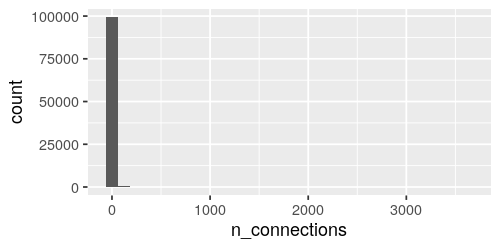

In [7]:
p = (gp.ggplot(
        ro.vectors.DataFrame(
            {'n_connections': ro.IntVector([n for x, n in iter(city.network.degree)])}
        )) + 
     gp.geom_histogram(gp.aes_string(x = 'n_connections'), bins=30) +
     gp.theme_grey(base_size=18)
)
image_png(p, width=500, height=250)

When limiting our observation to people who have less than 50 connections, we see that we are
not representing completely isolated individuals (people with not contact at with anyone),
and that we likely under-represent the number
of connections people have compared to the reality (during any given day at school or at the office,
we likely meet tens of people). Despite this limitation we will assume that this is
good enough for the puporse of illustration.

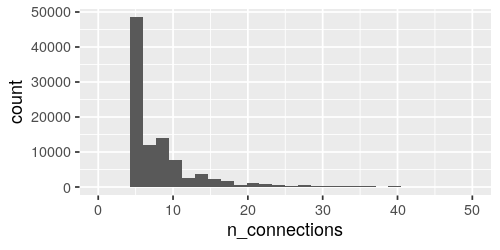

In [8]:
image_png(p + gp.xlim(0, 50), width=500, height=250)

We also need create a disease.

In [9]:
disease = Disease(contagiousness=1/20)

## Adding the initial infection cases

Now we create the initial infections in our populations. `n_init` is the number of initial infections. They are created by randomly picking the corresponding number of persons. We pick a relatively small number of infection
on purpose, to show the facility with which a contagious disease can spread.

In [10]:
n_init = 2
initial_cases = {}
for case in random.sample(set(k for k, v in iter(toy_city.network.degree) if v > 10 and v < 300), 3):
    initial_cases[case] = round(disease.duration_incubation())
    toy_city.incubating[case] = initial_cases[case]

print('%i initial cases (still incubating)' % n_init)
toy_city

2 initial cases (still incubating)


In [11]:
disease.duration_incubation

functools.partial(<bound method Random.lognormvariate of <random.Random object at 0x21c9798>>, 1.2, 0.5)

For our "real sized" city we start with 3 cases.

In [12]:
n_init = 3
initial_cases = {}
for case in random.sample(set(k for k, v in iter(city.network.degree) if v > 10 and v < 300), 3):
    initial_cases[case] = round(disease.duration_incubation())
    city.incubating[case] = initial_cases[case]

## First rules for a turn-by-turn simulation of an epidemic

Our code will work by updating our simulated world turn-by-turn (a bit like a board game when players play one after an other).

For now we break down what happens during a turn into:

1. update the incubations. This function will look at everyone incubating the disease, and for each
of their connections in the network whether they are transmitted the disease (by the equivalent of "rolling a dice" representing the risk, or contagiousness). For now we only consider the pool of incubating people as likely to transmit the disease, as we are simulating a situation where one symptoms appeared the people will be quarantined (e.g., not got to work).
2. update the sicknesses. For now this function will only decrease the counter to tracking the number of days until recovery
3. update the population with new incubations, new diseases, and new recoveries.

Our 3 steps are combined into a convenience wrapper function `simulate_day_sick_home()` that simulates the passing of one day, assuming that sick people (that is patients showing symptoms after the incubation period), are isolated (e.g., at home if mild case) and do not represent any risk of contaminating anyone else.

In [13]:
def simulate_day_sick_home(population, disease):
    new_contaminations, new_sicknesses = rh.update_incubations(population, disease)
    new_recoveries = rh.update_sicknesses(population)
    rh.update_population(population, disease, new_contaminations, new_sicknesses, new_recoveries)

## Running our first simulation

For contagiousness, the chance to transmit the disease,we are picking a value that is, say, `1/30`.
This means that every day there is one contamination for every connection on average (this would be
like rolling a 30-sided dice for every connection and rolling a 1 mean a contamination).

First we run our simulation on our toy city and visualize every few days how the epidemic it spreading.

In [14]:
# 3 months (3 times 30 days) should enough for our incubation and sickness durations, and the
# kind of network we are considering.
duration_of_simulation = 20
no_intervention = Monitor()
for day in range(duration_of_simulation):
    no_intervention.record(day, toy_city)
    simulate_day_sick_home(toy_city, disease)
    if day % 5 == 0:
        print('day %i: %i infected (%i incubating, %i sick)' %
              (day, len(toy_city.incubating) + len(toy_city.sick),
               len(toy_city.incubating), len(toy_city.sick)))
        display(toy_city)

day 0: 6 infected (6 incubating, 0 sick)


day 5: 60 infected (53 incubating, 7 sick)


day 10: 69 infected (21 incubating, 48 sick)


day 15: 26 infected (4 incubating, 22 sick)


In [15]:
# 3 months (3 times 30 days) should enough for our incubation and sickness durations, and the
# kind of network we are considering.
duration_of_simulation = 3*30
no_intervention = Monitor()
for day in range(duration_of_simulation):
    no_intervention.record(day, city)
    simulate_day_sick_home(city, disease)

Now we can plot the results of our simulation in the form of the number of people that are still susceptible, incubating, and sick.

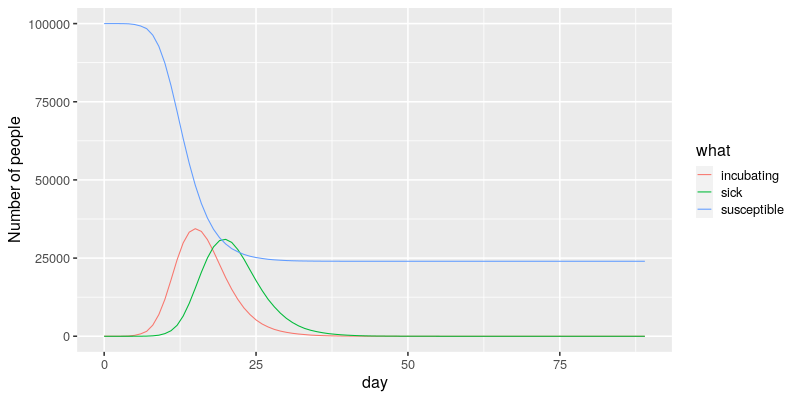

In [16]:
dataf_no_intervention = rh.build_dataframe(no_intervention)
p = (gp.ggplot(dataf_no_intervention) +
     gp.geom_line(gp.aes_string(x='day', y='count', color='what')) +
     gp.scale_y_continuous('Number of people') +
     gp.theme_grey(base_size=16)
)
image_png(p)

## Can we reproduce the "flatten the curve" graphics ?

In the "flatten the curve" graphics, the capacity of the healthcare system to manage the critical cases is represented as an horizontal line. We can take statistics about the relative number of critical care beds and use that number.
I use the following source: https://www.forbes.com/sites/niallmccarthy/2020/03/12/the-countries-with-the-most-critical-care-beds-per-capita-infographic/#23bd32017f86

We must also know the proportion of sicknesses that become critical and require the adapted care. I have seen reported a relatively large number of cases requiring critical care, but these number appear to be estimated from the number of diagnosed cases rather than from the larger total number of cases, most of which are believed to be asymptomatic or with mild symptoms. The number appear to also vary a lot by age group. In the end I picked 1% (`1/100`), but adjust as needed.

With this we can plot again the results of our simulation. This turns out to feel scarier that the "flatten the curve" picture and shows the magnitude of the issue.

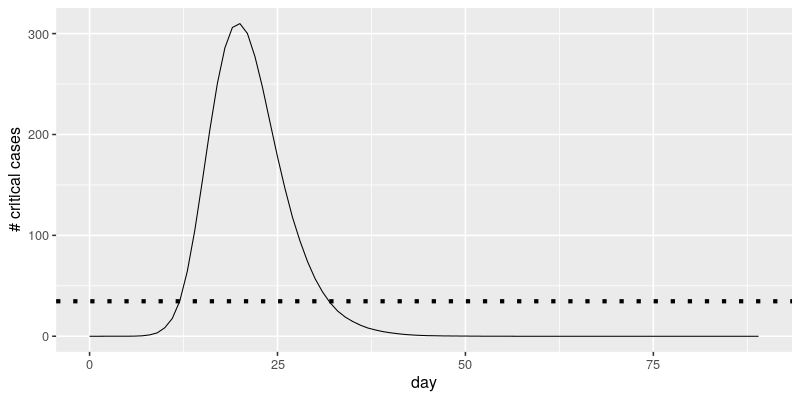

In [17]:
# Critical care bed per capita
BPC = 34.7/100000
critical_sickness = 1/100

p = (gp.ggplot(dataf_no_intervention.filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count * %f' % critical_sickness)) +
     gp.geom_hline(yintercept= BPC * n_pop, lty=3, lwd=2) +
     gp.scale_y_continuous('# critical cases') +
     gp.theme_grey(base_size=16)
)
image_png(p)

Now let's simulate the cancellation of gathering. To achieve simply, we remove most of the connections in the network where a person is in contact with more than a threshold number of people (`max_size`). This is quite imperfect but it will help us reason about the effect of social distancing.

We can visualize the effect of social distancing in our model: a number of connections between people are removed, limiting the ability of the contagious agent to spread.

In [18]:
toy_city.reset()
display(toy_city)
toy_cancelled_connections = rh.connections_to_cancel(toy_city, 3, 3)
for n_a, n_b in toy_cancelled_connections:
  toy_city.network.get_edge_data(n_a, n_b)['color'] = 'transparent'
display(toy_city)
for n_a, n_b in toy_cancelled_connections:
  toy_city.network.add_edge(n_a, n_b, color='gray')

Let's simulate for `max_size` equal to 50.

In [19]:
max_size = 50
cancelled_events = rh.simulate_cancelled_events(city, disease, max_size, simulate_day_sick_home,
                                                initial_cases,
                                                ndays=duration_of_simulation)

There is an effect, and we can see that the peak (highest number of cases at any point in time) is lower, delayed, and with the number of sickness distributed over a longer period of time. So social distancing can give previous additional time for society to prepare.

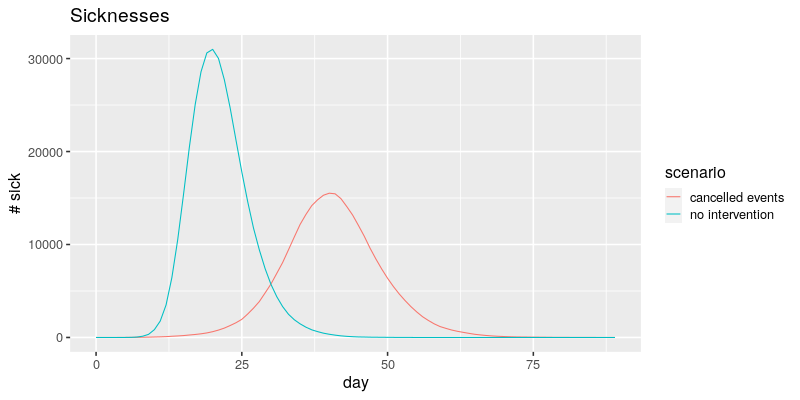

In [20]:
dataf = (dplyr.DataFrame(
    dplyr.dplyr.bind_rows(
        dataf_no_intervention.mutate(scenario='"no intervention"'),
        rh.build_dataframe(cancelled_events).mutate(scenario='"cancelled events"'))
    )
)
p = (gp.ggplot(dataf.filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count', color='scenario')) +
     gp.scale_y_continuous('# sick') +
     gp.theme_grey(base_size=16) +
     gp.ggtitle('Sicknesses')
)
image_png(p)

We can look at the number of people in the different states in our model.
Not only the intervention (social distancing) reduces the number of sick individuals at the peak,
but it also reduces the total fraction of the population that will get infected.

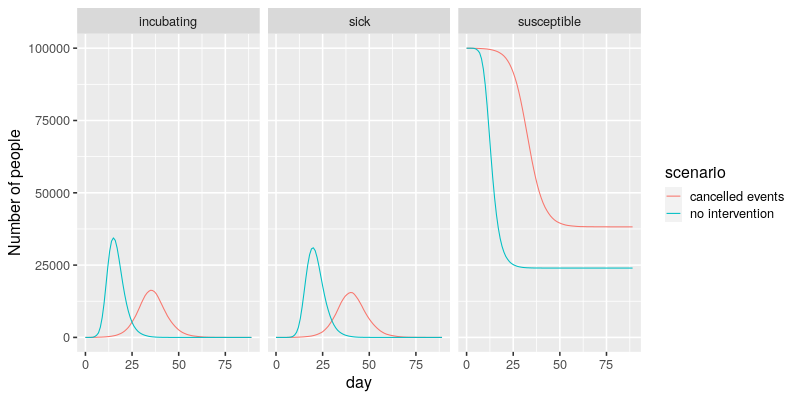

In [21]:
p = (gp.ggplot(dataf) +
     gp.geom_line(gp.aes_string(x='day', y='count', color='scenario')) +
     gp.scale_y_continuous('Number of people') +
     gp.facet_wrap('~ what') +
     gp.theme_grey(base_size=16)
)
image_png(p)

We can also simulate various levels of strictness for social distancing.

In [22]:
res = []
for max_size in (150, 100, 75, 50, 30, 20, 10, 5):
    cancelled_various_events = rh.simulate_cancelled_events(city, disease, max_size, simulate_day_sick_home,
                                                            initial_cases,
                                                            ndays=duration_of_simulation)
    res.append(rh.build_dataframe(cancelled_various_events).mutate(max_size=max_size))

dataf_distancing = dplyr.DataFrame(
    dplyr.dplyr.bind_rows(*res)
)

There is a lot to unpack in the figure, but in a nutshell we see that:
- significant social distancing might be need to achieve a drastic effect, but it is otherwise
  already perceptible even when less stringent 
- there is some variability (remember that each simulation has stochastic components,
  that is there is randomness in how of the disease is spreading). This in itself is interesting
  and will likely be the subject of an other notebook).

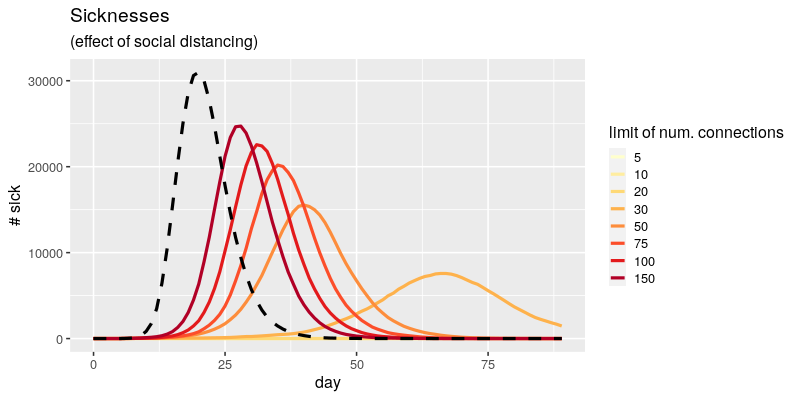

In [23]:
p = (gp.ggplot(dataf_no_intervention.filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count',
                                group='max_size',
                                color='factor(max_size, ordered = TRUE)'),
                  lwd=1.5,
                  data=dataf_distancing.filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count'), lwd=1.5, lty=2) +
     gp.scale_y_continuous('# sick') +
     gp.scale_color_brewer('limit of num. connections', palette='YlOrRd') +
     gp.theme_grey(base_size=16) +
     gp.ggtitle('Sicknesses',
                sub='(effect of social distancing)')
)
image_png(p)

And we are able to reproduce the "flatten the curve" figure with our simple simulation.

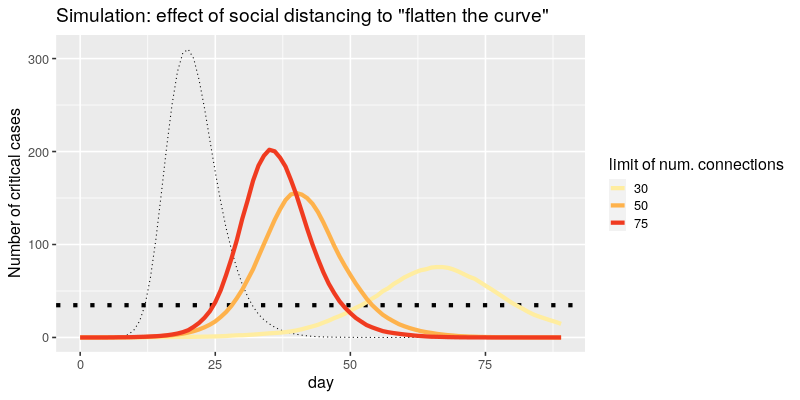

In [24]:
p = (gp.ggplot(dataf_no_intervention.filter('what == "sick"')) +
     gp.geom_hline(yintercept= BPC * n_pop, lty=3, lwd=2) +
     gp.geom_line(gp.aes_string(x='day', y='count * %f' % critical_sickness),
                  lty=3) +
     gp.geom_line(gp.aes_string(x='day', y='count * %f' % critical_sickness,
                                group='max_size',
                                color='factor(max_size, ordered = TRUE)'),
                  lwd=2,
                  data=dataf_distancing.filter('what == "sick"',
                                        'max_size %in% c(30, 50, 75)')) +
     gp.scale_y_continuous('Number of critical cases') +
     gp.scale_color_brewer('limit of num. connections', palette='YlOrRd') +
     gp.theme_grey(base_size=16) +
     gp.ggtitle('Simulation: effect of social distancing to "flatten the curve"')
)
image_png(p)

In [25]:
max_size = 75
res = []
for delay in (1, 3, 7, 14, 21):
    for max_size in (1, 3, 5, 10, 25, 50, 75, 100):
        delayed_response = rh.simulate_cancelled_events(
            city, disease, max_size,
            simulate_day_sick_home,
            initial_cases,
            delay=delay, ndays=4*30
        )
        res.append(rh.build_dataframe(delayed_response).mutate(delay=delay,
                                                               max_size=max_size,
                                                               ndays=4*30))

dataf_delay = dplyr.DataFrame(
    dplyr.dplyr.bind_rows(*res)
)

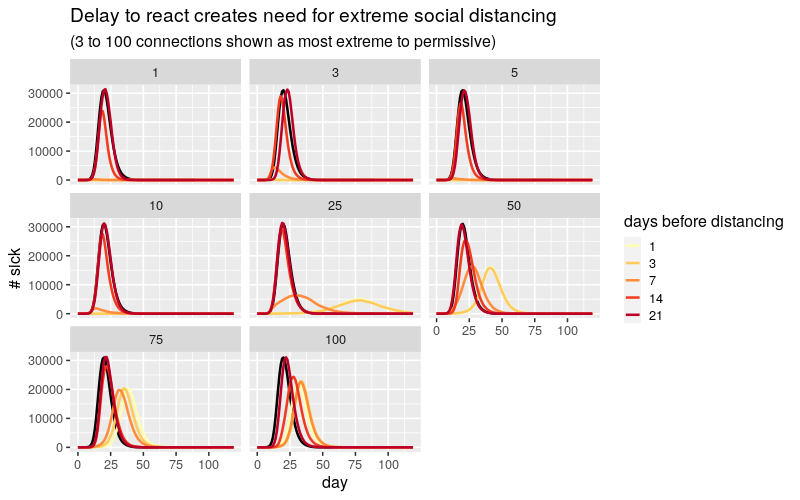

In [26]:
p = (gp.ggplot(dataf_no_intervention
               .filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count'), lwd=1.2) +
     gp.geom_line(gp.aes_string(x='day', y='count',
                                group='delay',
                                color='factor(delay, ordered = TRUE)'),
                  lwd=1.2,
                  data=(dataf_delay
                        .filter('what == "sick"'))
                 ) +
     gp.scale_y_continuous('# sick') +
     gp.scale_color_brewer('days before distancing', palette='YlOrRd') +
     gp.facet_wrap('~ max_size') +
     gp.theme_grey(base_size=16) +
     gp.ggtitle('Delay to react creates need for extreme social distancing',
                sub='(3 to 100 connections shown as most extreme to permissive)')
)
image_png(p, height=500)

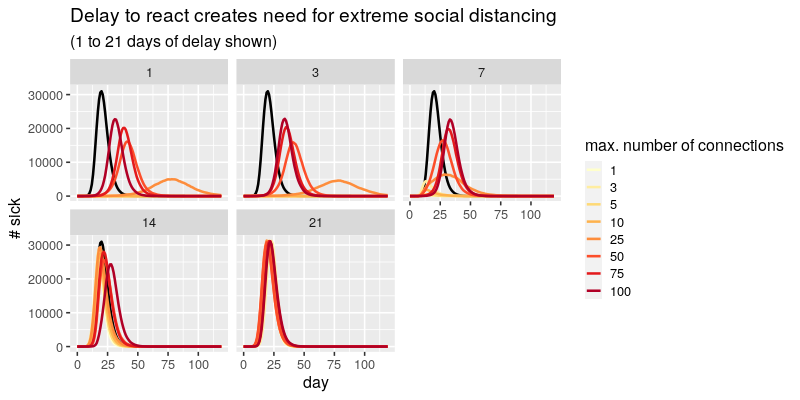

In [27]:
p = (gp.ggplot(dataf_no_intervention
               .filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count'), lwd=1.2) +
     gp.geom_line(gp.aes_string(x='day', y='count',
                                group='max_size',
                                color='factor(max_size, ordered = TRUE)'),
                  lwd=1.2,
                  data=(dataf_delay
                        .filter('what == "sick"'))
                 ) +
     gp.scale_y_continuous('# sick') +
     gp.scale_color_brewer('max. number of connections', palette='YlOrRd') +
     gp.facet_wrap('~ delay') +
     gp.theme_grey(base_size=16) +
     gp.ggtitle('Delay to react creates need for extreme social distancing',
                sub='(1 to 21 days of delay shown)')
)
image_png(p, height=400)

## Still working when sick (with symptoms)

So far we simulated the situation where one the symptoms are present the person is isolated and the risks of contaminations are null. We can also simulate the situation where a fraction of the population down with the sickness keep transmitting the dieases (e.g., because returning to work before recovery).

In [28]:
def update_sick_still_work(population, disease,
                           fraction=5/100):
    new_contaminations = []
    for case in population.sick:
        if random.random() > fraction:
            continue
        for person in population.network.neighbors(case):
            if person not in population.susceptible:
                continue
            if random.random() <= disease.contagiousness:
                population.susceptible.remove(person)
                new_contaminations.append(person)
    return new_contaminations


def simulate_day_sick_still_work(population, disease, fraction_sick=5/100):
    new_contaminations, new_sicknesses = rh.update_incubations(population, disease)
    new_contaminations.extend(
        update_sick_still_work(population, disease,
                               fraction=fraction_sick)
    )
    new_recoveries = rh.update_sicknesses(population)
    rh.update_population(population, disease, new_contaminations, new_sicknesses, new_recoveries)

In [29]:
city.reset()
for case in initial_cases:
    city.incubating[case] = initial_cases[case]
sick_still_work = Monitor()
for d in range(1, duration_of_simulation):
    sick_still_work.record(d, city)
    simulate_day_sick_still_work(city, disease, fraction_sick=5/100)

dataf = (dplyr.DataFrame(
    dplyr.dplyr.bind_rows(
        dataf_no_intervention.mutate(scenario='"no intervention"'),
        rh.build_dataframe(sick_still_work).mutate(scenario='"sick still work"'))
    )
)

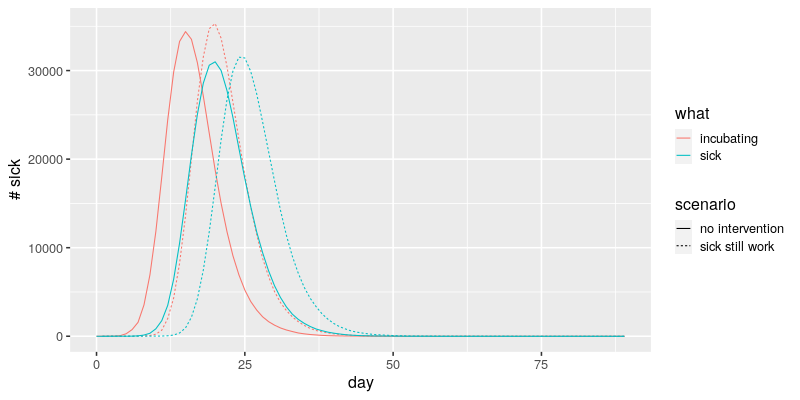

In [30]:
p = (gp.ggplot(dataf.filter('what %in% c("incubating", "sick")')) +
     gp.geom_line(gp.aes_string(x='day', y='count', color='what', lty='scenario')) +
     gp.scale_y_continuous('# sick') +
     gp.theme_grey(base_size=16)
)
image_png(p)

In [31]:
res = []
for fraction_sick in (5/100, 10/100, 1/3, 1/2):
    city.reset()
    for case in initial_cases:
        city.incubating[case] = initial_cases[case]
    monitor = Monitor()
    for d in range(1, 3*30):
        monitor.record(d, city)
        simulate_day_sick_still_work(city, disease, fraction_sick=fraction_sick)
    res.append(
        rh.build_dataframe(monitor)
        .mutate(scenario='"sick still work"', fraction=fraction_sick)
    )

dataf = (dplyr.DataFrame(
    dplyr.dplyr.bind_rows(
        *res
    )
))

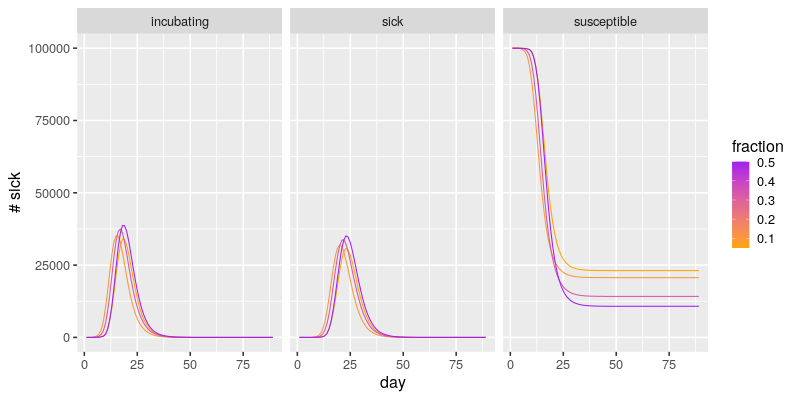

In [32]:
p = (gp.ggplot(dataf) +
     gp.geom_line(gp.aes_string(x='day', y='count',
                                group='fraction',
                                color='fraction')) +
     gp.facet_wrap('~what') +
     gp.scale_y_continuous('# sick') +
     gp.scale_color_gradient(low = "orange", high = "purple") +
     gp.theme_grey(base_size=16)
)
image_png(p)

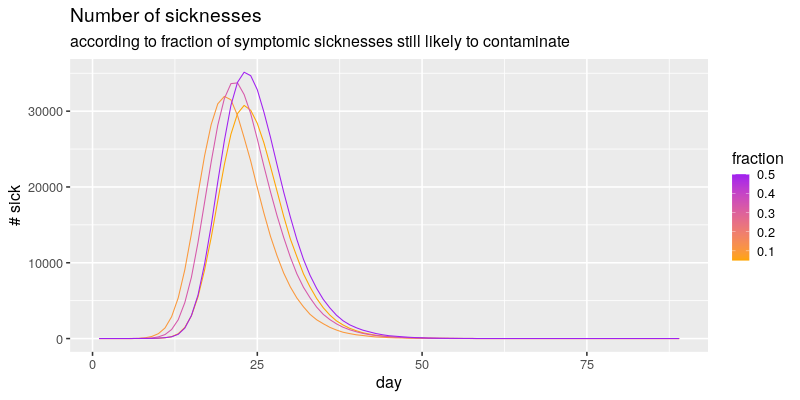

In [33]:
p = (gp.ggplot(dataf.filter('what == "sick"')) +
     gp.geom_line(gp.aes_string(x='day', y='count',
                                group='fraction',
                                color='fraction')) +
     gp.scale_y_continuous('# sick') +
     gp.scale_color_gradient(low='orange', high='purple') +
     gp.ggtitle('Number of sicknesses',
                sub='according to fraction of symptomic sicknesses still likely to contaminate') +
     gp.theme_grey(base_size=16)
)
image_png(p)